![](img/563_banner.png)

# Lecture 6: Using word embeddings, manifold learning

UBC Master of Data Science program, 2021-22

Instructor: Varada Kolhatkar

## Lecture plan, imports, and LOs

### Lecture plan

- Demo from last lecture (~5 mins)
- Context and motivation (~5 mins)
- Using word embeddings in text classification (~20 mins)
- Q&A (~5 mins)
- Break (~5 mins)
- Product similarity using word2vec (~15 mins)
- t-SNE (~15 mins)
- Final remarks, summary, reflection (~5 mins)

### Imports 

In [1]:
import os
import random
import sys
import time

import numpy as np
import pandas as pd

sys.path.append("code/.")

import re
import string

import matplotlib.pyplot as plt
from sklearn import datasets, manifold
from sklearn.decomposition import PCA
from plotting_functions import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from support_functions import *

plt.rcParams["font.size"] = 16
import matplotlib.cm as cm

%matplotlib inline
pd.set_option("display.max_colwidth", 0)

<br><br>

### Learning outcomes

From this lecture, students are expected to be able to:

- Explain how could we evaluate quality of word embeddings.  
- Explain how can you represent sentences and text with word representations. 
- Use word embeddings in text classification and document clustering using spaCy. 
- Explain limitations associated with the approaches used to create sentence embeddings from word embeddings.   
- Use Word2Vec algorithm to build a product recommendation system using customer purchase history.  
- Visualize data using t-SNE.  

<br><br><br><br>

## Context and motivation

### Two main topics for today

- Using word embeddings in ML applications 
- Manifold learning 

### Using embeddings in machine learning applications

- In the last lecture we talked about Word2Vec. 
- We used word embeddings to find similarity between words and phrases and to find analogies.  
- How do we actually use them in machine learning applications?
    - How do we feed them to ML models?     

### Evaluating quality of word vectors

- Before using word embeddings in your applications, it's a good idea to examine their quality. 
- How do we evaluate the quality of embeddings? 
    - Examine a number of word pairs for similarity scores. 
    - Examine different analogies for stereotypes and biases they encode.  
    - Visualize embeddings in two dimensions. 

### Example evaluation with TOEFL multiple-choice vocabulary tests

* Compare it to human judgment on the similarity between words.
* Taking TOEFL multiple-choice vocabulary tests.
    - **Levied**  is closest in meaning to:
      _imposed, believed, requested, correlated_

In [2]:
import gensim.downloader as api

google_news_vectors = api.load("word2vec-google-news-300")

In [3]:
google_news_vectors.most_similar("levied")

[('levying', 0.7044811844825745),
 ('Dedicating_fines', 0.5996160507202148),
 ('levies', 0.5890565514564514),
 ('imposed', 0.5830395221710205),
 ('fines_levied', 0.5777179002761841),
 ('Levying', 0.5654435753822327),
 ('Osteens_paid', 0.5609164834022522),
 ('levy', 0.5559998750686646),
 ('fines', 0.5462918281555176),
 ('Longe_Velazquez', 0.5221693515777588)]

### Visualization of embeddings

- Let's visualize word vectors for specific words from Google News pre-trained embeddings. 

In [4]:
import gensim.downloader as api

google_news_vectors = api.load("word2vec-google-news-300")

In [5]:
words = google_news_vectors.index_to_key

In [6]:
google_news_vectors["peace"].shape

(300,)

The vectors are 300 dimensional. How do we visualize them? 

In [7]:
positive = [
    "amazing",
    "admirable",
    "awesome",
    "outstanding",
    "extraordinary",
    "exceptional",
    "fantastic",
]
negative = [
    "rotten",
    "stinky",
    "dirty",
    "annoying",
    "disgusting",
    "fake",
    "hideous",
    "bad",
    "waste",
    "awful",
]

neutral = [
    "apathetic",
    "urgent",
    "detached",
    "indifferent",
    "wikipedia",
]

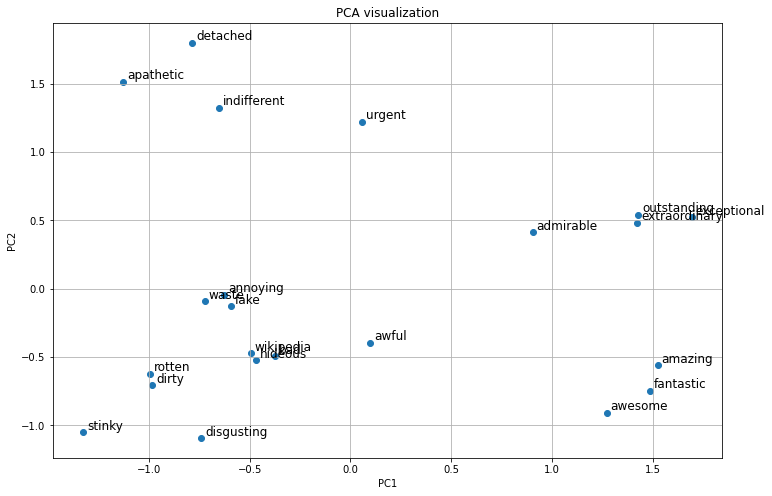

In [8]:
plt.figure(figsize=(12, 8))
plt.title("PCA visualization")

X = google_news_vectors[positive + negative + neutral]
pca = PCA(n_components=2)
Z = pca.fit_transform(X)
# # create a scatter plot of the projection
plt.scatter(Z[:, 0], Z[:, 1])
words = positive + negative + neutral
for i, word in enumerate(words):
    plt.annotate(word, xy=(Z[i, 0] + 0.02, Z[i, 1] + 0.02), size=12)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid()
plt.show()

- Even in two dimensional projects we see three distinct clusters for positive, negative, and neutral words! 
- Not sure why the word _wikipedia_ is placed among negative words. 

In [9]:
google_news_vectors.most_similar("wikipedia", 10)

[('en.wikipedia.org_wiki', 0.489251971244812),
 ('Wikepedia', 0.47150564193725586),
 ('google', 0.45259717106819153),
 ('faqs', 0.444589763879776),
 ('htm', 0.4418445825576782),
 ('cgi_bin', 0.4352087676525116),
 ('Wikipedia', 0.4266732335090637),
 ('##.html', 0.42112863063812256),
 ('answers.com', 0.4172719120979309),
 ('Wikpedia', 0.41681769490242004)]

### Motivation for manifold learning 

- PCA is good first approach to transform data so that we can plot it in two dimensions
- There is a class of algorithms for visualization called **manifold learning algorithms** which allow for much more complex mappings and better visualizations. 
- A particularly useful one is the t-SNE algorithm which we'll talk about in the second part of the lecture. 

<br><br><br><br>

## Using word embeddings in document similarity and text classification

### Representing documents using word embeddings

- Assuming that we have reasonable representations of words. 
- How do we represent meaning of paragraphs or documents?
- Two simple approaches
    - Averaging embeddings
    - Concatenating embeddings

### Averaging embeddings

<blockquote>
All empty promises
</blockquote>
    
$(embedding(all) + embedding(empty) + embedding(promise))/3$

### Average embeddings with spaCy

- We can do this conveniently with [spaCy](https://spacy.io/usage/linguistic-features#vectors-similarity). 
- We need `en_core_web_md` or bigger model to access word vectors. 
- You can download the model by going to command line and in your course `conda` environment and download `en_core_web_md` as follows.   

```
conda activate 563
python -m spacy download en_core_web_md
```

In [10]:
import spacy

nlp = spacy.load("en_core_web_md")

We can access word vectors for individual words in `spaCy` as follows. 

In [11]:
nlp("empty").vector[0:10]

array([ 1.0127  , -0.20527 , -0.24555 , -0.076636,  0.11981 ,  0.21642 ,
       -0.55584 ,  0.020206,  0.39778 ,  1.7218  ], dtype=float32)

We can get average embeddings for a sentence or a document in `spaCy` as follows: 

In [12]:
s = "All empty promises"
doc = nlp(s)
avg_sent_emb = doc.vector
print(avg_sent_emb.shape)
print("Word vector for: {}\n{}".format((s), (avg_sent_emb[0:10])))

(300,)
Word vector for: All empty promises
[ 0.28903252 -0.09684668 -0.11497    -0.26554868  0.01983    -0.111594
 -0.10229333  0.126915    0.17705734  2.1837332 ]


### Similarity between documents 

- Now that we have representation for sentences we can get similarity between documents as follows. 
- Note that this is based on average embeddings of each sentence. 

In [13]:
doc1 = nlp("Deep learning is very popular these days.")
doc2 = nlp("Data Science is dominated by neural networks.")
doc3 = nlp("Today I ate home-made fresh bread.")

# Similarity of two documents
print(doc1, "<->", doc2, doc1.similarity(doc2))
print(doc1, "<->", doc3, doc2.similarity(doc3))

Deep learning is very popular these days. <-> Data Science is dominated by neural networks. 0.7053992325726607
Deep learning is very popular these days. <-> Today I ate home-made fresh bread. 0.5018738028374871


- Do these scores make sense? 
    - Kind of. 

###  Airline sentiment analysis using average embedding representation 

- Let's try average embedding representation for airline sentiment analysis.
- You can download the dataset from [here](https://www.kaggle.com/jaskarancr/airline-sentiment-dataset). 

In [14]:
df = pd.read_csv("data/Airline-Sentiment-2-w-AA.csv", encoding="ISO-8859-1")
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada)
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada)


What are we trying to do?

- Try sentiment analysis with bag-of-words representation 
- Try sentiment analysis with embedding representation

In [15]:
from sklearn.model_selection import cross_validate, train_test_split

train_df, test_df = train_test_split(df, test_size=0.7, random_state=123)
X_train, y_train = train_df["text"], train_df["airline_sentiment"]
X_test, y_test = test_df["text"], test_df["airline_sentiment"]

### Bag-of-words representation for sentiment analysis

In [16]:
pipe = make_pipeline(
    CountVectorizer(stop_words="english"), LogisticRegression(max_iter=1000)
)
pipe.named_steps["countvectorizer"].fit(X_train)
X_train_transformed = pipe.named_steps["countvectorizer"].transform(X_train)
print("Data matrix shape:", X_train_transformed.shape)
pipe.fit(X_train, y_train);

Data matrix shape: (4392, 7290)


In [17]:
print("Train accuracy {:.2f}".format(pipe.score(X_train, y_train)))
print("Test accuracy {:.2f}".format(pipe.score(X_test, y_test)))

Train accuracy 0.96
Test accuracy 0.76


- Large gap between train and test scores. Overfitting. 
- Test score is kind of low. 

### Sentiment analysis with average embedding representation

- Let's try average embedding representation using `spaCy`. 
- How can we create average embedding representation for each example using `spaCy`? 
- When you want to process large volumes of text, pre-trained models from `spaCy` are usually more efficient if you let them work on batches of texts. `spaCy`’s `nlp.pipe` method takes an iterable of texts and yields processed Doc objects. The batching is done internally.

In [18]:
X_train_embeddings = pd.DataFrame([text.vector for text in nlp.pipe(X_train)])
X_test_embeddings = pd.DataFrame([text.vector for text in nlp.pipe(X_test)])

- We have reduced dimensionality from 7,290 to 300! 
- Let's examine the average embedding representation. 

In [19]:
X_train_embeddings.shape

(4392, 300)

In [20]:
X_train_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.029802,0.135232,-0.099884,-0.028636,0.114258,-0.022045,0.053859,-0.039168,0.007095,1.629201,...,-0.066421,0.029331,-0.053302,-0.016723,0.201502,-0.077646,-0.052267,-0.057924,0.005758,0.083519
1,-0.391330,-0.153766,-0.328562,-0.165922,-0.038374,-0.103966,0.166155,-0.491635,0.130192,1.173175,...,0.097738,-0.283210,-0.440315,-0.437440,0.198071,-0.097030,-0.095754,0.137083,-0.027705,0.114614
2,-0.053622,0.227409,-0.188868,-0.137507,0.125334,0.036247,0.034082,-0.025592,-0.019571,2.266759,...,-0.201549,0.034009,-0.097438,-0.077629,-0.012997,0.046473,-0.099252,-0.064402,-0.015745,0.138882
3,-0.047002,0.005797,-0.120038,0.073476,-0.070184,-0.090068,-0.076702,-0.023419,0.065136,1.263095,...,0.105383,0.097616,0.022162,0.034611,0.004864,0.030592,0.065789,0.023233,-0.101005,-0.013554
4,0.027842,0.152027,-0.167062,-0.017180,0.153128,-0.039681,-0.028728,-0.205003,-0.014879,1.803080,...,-0.084245,-0.037855,-0.019518,-0.144188,0.072062,-0.016972,-0.024690,-0.009534,0.100698,0.035332


### Sentiment classification using average embeddings 

- What are the train and test accuracies with average word embedding representation? 

In [21]:
lgr = LogisticRegression(max_iter=1000)
lgr.fit(X_train_embeddings, y_train)
print("Train accuracy {:.2f}".format(lgr.score(X_train_embeddings, y_train)))
print("Test accuracy {:.2f}".format(lgr.score(X_test_embeddings, y_test)))

Train accuracy 0.82
Test accuracy 0.80


- The test accuracy is a bit better with less overfitting. 
- Note that the embeddings are trained on a completely different corpus and we are leveraging semantic similarities it has learned from this huge training corpus to represent sentences from our fairly small corpus.

### `spaCy`'s pre-trained embeddings 
- `spaCy`'s pre-trained embeddings are trained on [OntoNotes corpus](https://catalog.ldc.upenn.edu/LDC2013T19).
- This corpus has a collection of different styles of texts such as telephone conversations, newswire, newsgroups, broadcast news, broadcast conversation, weblogs, religious texts. 
- If you are working with a specific style (e.g., tweets or healthcare) you may want to use different pre-trained embeddings. In that case you'll have to get average embeddings on your own. 

### Comments on using average embeddings in your applications

- Maintain realistic expectations about the information average embeddings provide. 
- Since embedding of a phrase or a sentence is the average of embeddings of words in it we do not necessarily get expected representation of text. 
    - Example: embedding of "machine learning" is going to be average embedding of "machine" and "learning" which is not necessarily representative of the phrase "machine learning". 
- For long sentences or documents the average embedding can get very noisy, as there will be a mix of many different signals.  

### Concatenating embeddings

<blockquote>
All empty promises
</blockquote>

- $embedding(all)$ $embedding(empty)$ $embedding(promise)$
- Might have to chop some text in order to make fixed-sized vectors to feed into ML algorithms.


**You'll see real benefit of word embeddings when we talk about recurrent neural networks (RNNs)!**

## Extensions and more advanced models

- [Include phrases](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
    * New York : New York Times :: Vancouver : Vancouver Sun?
- Contextual representations of words ([ELMo](https://github.com/allenai/allennlp/blob/master/tutorials/how_to/elmo.md))
    * I went to the **bank** to deposit a cheque. 
    * She loves to walk along the <b>bank</b> of a river, and look into the water.
- [doc2vec](https://radimrehurek.com/gensim/models/doc2vec.html) and [paragraph2vec](https://arxiv.org/abs/1405.4053)
    * Learns fixed-length feature representations from variable-length pieces of texts

<br><br><br><br>

## ❓❓ Questions for you
iClicker cloud join link: https://join.iclicker.com/MA16T

### Exercise 6.1 Select all of the following statements which are **True** (iClicker)

- (A) Consider Google News pre-trained word2vec embeddings. If I take word vector for "Computer_Science" and an average of the word vectors for "Computer" and "Science", they will result in the same word vector.
- (B) One of the problems with using pre-trained embeddings built on a text in a particular domain with text in another domain is that there could be many unknown words. 
- (C) Once you have a trained word2vec model, finding most similar items means training $k$-nearest neighbours classifier on your word embeddings. 
- (D) Instead of getting sentence embeddings, you could have used average word embeddings of recipe names in lab1. 
- (E) When you are using average embedding representation on large documents, the representation can get quite noisy.  

<br><br><br><br>

```{admonition} Exercise 6.1: V's Solutions!
:class: tip, dropdown

- (A) False. Computer_Science would occur in different contexts than average of computer and science.
- (B) True. Also, words can have slightly different meaning in different domains. For example, the word "pandas" would have a different meaning in data science vs. forest sciences, and depending upon the training corpus, the representation of the word would be different.
- (C) False. Finding most similar items means finding k nearest neighbours. But there is no classifier involved here; there are no labels and no supervised models.
- (D) True. The results might not have been that great but we could have used average word embeddings. 
- (E) True. 
```

- Discuss the problem associated with using concatenation approach to represent sentences or paragraphs. 


<br><br><br><br>

## Word2Vec for product recommendation

###  Word2Vec beyond text and words

- Word2Vec is not limited to text and words and it has been used in many different domains and for many different applications.
    - Examples
        - [graph2vec](https://github.com/benedekrozemberczki/graph2vec)
        - [node2vec](https://github.com/topics/node2vec)
        - [song2vec](https://github.com/lihenryhfl/song2vec)
        - ...             

### Using Word2Vec for product recommendation

- In the lab you will be using Word2Vec for product recommendation. 
- Word2Vec exploits the sequential nature of text data and assumes that the words in similar contexts tend to be similar or related. 
- We could apply the same intuition to product purchasing behaviour of customers! 
    - If we consider products bought together with each other as contexts of each other, then we can say that the products that occur in similar contexts are related or similar. 
   

### Purchase history example
- Bike light and waterproof pants occur in similar contexts
- How about recommending waterproof pants to Sam and Bike light to Jamie?

<img src="img/customer_purchase_history_example.png" width="600" height="600">

(Credit: https://www.bicycling.com/bikes-gear/g20011461/winter-cycling-gear-0/)

### How to train Word2Vec for this?

- What are words, sentences, and vocabulary?
    - Words $\rightarrow$ products
    - Sentences $\rightarrow$ purchase histories 
    - Vocabulary $\rightarrow$ all unique products

<img src="img/customer_purchase_history_labeled.png" width="800" height="800">

(Credit: https://www.bicycling.com/bikes-gear/g20011461/winter-cycling-gear-0/)

### Training the Word2Vec algorithm for product recommendation 
- The idea is to model similarity/relatedness between products based on the distributional hypothesis; the products that occur in similar contexts tend to be related/similar.  
- Using the Word2Vec algorithm, we learn short and dense representations for all products based on the contexts in which they appear.
- If we have a large dataset, we learn meaningful representations of products.  

### Training Word2Vec for product recommendation 

- To train Word2Vec model we need: 
    - preprocessed corpus
    - embedding dimension
    - window size

###  Preparing the data

- Create a list of lists of purchase histories for all customers. 
- We want the data in the following format.

    ```
    [
     [item1_customer1, item2_customer1, ...], # purchase history for customer1
     [item1_customer2, item2_customer2, ...], # purchase history for customer2
     ...
     [item1_customer100, item2_customer100, ...], # purchase history for customer100
     ...
     ]
    ```

## Preparing the data

- Each inner list corresponds to purchase history of a customer. 
- Elements of each inner list are items bought by that particular customer ordered by time when they were bought. 
- Each inner list of items purchased by a customer is equivalent to a sentence in a typical Word2Vec model. 
    - ```[item1_customer1, item2_customer1, ....]``` 
- Each item within each inner list corresponds to a word in a typical Word2Vec model. 
    - `item1_customer2` would be equivalent to a word in a typical Word2Vec model. 
- The items following and preceding a given item form context of the given item.  


### Training Word2Vec for product recommendation: window size, embedding dimensions

- Now that you have input for the Word2Vec algorithm, you can train is by setting the appropriate hyperparameters
    - window size
    - embedding dimensions

### What to do with the trained product embeddings? 

- With the trained model, we can find products similar to the product of interest in the vector space and recommend it to the user.  
- Example: Recommend waterproof pants to Sam and bike light to Jamie.


<img src="img/customer_purchase_history_example.png" width="600" height="600">

(Credit: https://www.bicycling.com/bikes-gear/g20011461/winter-cycling-gear-0/)

<br><br><br><br>

## Manifold learning with t-SNE

### Visualizing high dimensional data

- So far we have been using PCA for dimensionality reduction and visualizing high dimensional data. 
- Recall that PCA is a linear dimensionality reduction technique. 
- **Manifold learning** is a class of algorithms that apply complicated non-linear transformations on the data. 
- These techniques are mostly used for visualization. 

### Manifold learning idea

- The idea is that you have some shape in 2D and it's embedded in a higher dimensional space in some weird twisted way and you want to recover the underlying structure of the data in two dimensions.  
- A classic example is a swiss role, as shown below. 
- The unrolled 2D layout of the swiss role is on the right.   


<img src="img/swiss_roll.png" width="800" height="800">

    
[source](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L31.pdf)

### Other methods for visualization 

- A number of manifold learning methods are out there which apply more complicated transformations on the data. 
    - [Multi-dimensional scaling (MDS)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html)
    - [ISOMAP](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap)
    - [Locally linear embedding (LLE)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html)
    - [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

- They are based on the idea that we can directly optimize the location of $Z_i$ values in the transformed space because that's what we care about in visualization. 

### t-distributed Stochastic Neighbour Embedding (t-SNE)

- The main idea is to find a low dimensional (usually two-dimensional) representation of the data that preserves the distances between points as best as possible.
- Start with a random embedding in the lower dimensional space 
- Iteratively update points to make 
    - close points in the original space closer in the new space (more emphasis)
    - Far apart points in the original space further apart      

Let's try it out on the swiss roll toy dataset. 

In [22]:
import warnings
warnings.filterwarnings("ignore")

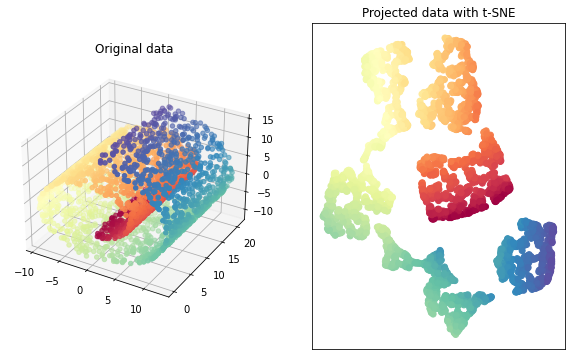

In [23]:
from sklearn.datasets import make_swiss_roll
from mpl_toolkits.mplot3d import Axes3D

X, colour = make_swiss_roll(n_samples=3000, noise=0.01)

from sklearn.manifold import TSNE

tsne = TSNE(random_state=42, init='pca')
swiss_tsne = tsne.fit_transform(X)
plot_swiss_roll(X, colour, swiss_tsne)


- It's identifying clear clusters from this this complicated structure.  
- We're not going to talk about the details of the algorithm. 
- My goal is to give you an intuition, let you know that it exists, and show you how to use it for visualization. 

### t-SNE
 
- In particular, in t-SNE, we use distances between points to come up with a probability distribution for the neighborhood of each point.
    - closer points have a higher probability to be neighbors
- Then, we look for a configuration in the low dimensional space that approximates these probabilities. 

### (Optional) In the high dimensional space
- In the original space, calculate:
$$
p_{j|i} = \frac{\exp(||x_{i}-x_j||^2/2\sigma^2)}{\sum_{i\neq k}\exp(||x_{i}-x_k||^2/2\sigma^2)},
$$
and $p_{i|i}=0$. Then, obtain the probability:

$$p_{ij} = \frac{p_{j|i}+p_{i|j}}{2n}$$

### (Optional) In the low dimensional space

- Then, for the projected points we use
$$
q_{ij}= \frac{\left(1+||z_{i}-z_j||^2\right)^{-1}}{\sum_{i\neq k}\left(1+||z_{i}-z_k||^2\right)^{-1}}
$$


- We want our $q_{j|i}$ to be as close as possible to $p_{j|i}$

### (Optional) Kullback-Leibler divergence

- To check how close $q_{j|i}$ and $p_{j|i}$ are to each other, we can use the divergence
$$
KL(p,q) = \sum_{i,j}p_{ij}\log\left(\frac{p_{ij}}{q_{ij}}\right)
$$

- You can use gradient-descent to optimize this function;


- Note that this function is not symmetric, i.e., different error will be penalized differently. Let's analyze that.

### (Optional)

- If the distance between $x_i$ and $x_j$ is large in the original high dimensional space, then $p_{j|i}$ is small. Then, even if you make $y_i$ and $y_j$ close to each other (large $q_{j|i}$), the objective function will not be affected much;


- But if $x_i$ is close to $x_j$, then $p_{j|i}$ is large, and if you use  $y_i$ and $y_j$ far from each other (small $q_{j|i}$), then the objective function will be highly impacted;


- Therefore, this method is focused on keeping the local structure;

### (Optional) Distances considered in t-SNE

- We consider three distances: $d_1$, $d_2$, and $d_3$
- $d_1 \rightarrow$ For each data point $x_i$, compute probability that $x_j$ is a neighbour
    - For each point if we want to pick one of its neighbors at random weighted by distance, how likely is it we will pick some neighbor $j$? 
- $d_2 \rightarrow$ For each transformed point $z_i$ compute the probability that each $z_j$ is a neighbour
- $d_3 \rightarrow$ Compare $x_i$ and $z_i$ using an entropy-like measure: 
    - How much "randomness" is in probabilities of $x_i$ if you know the $z_i$

### t-SNE and PCA on the digits dataset

Let's try this out on the digits dataset. 

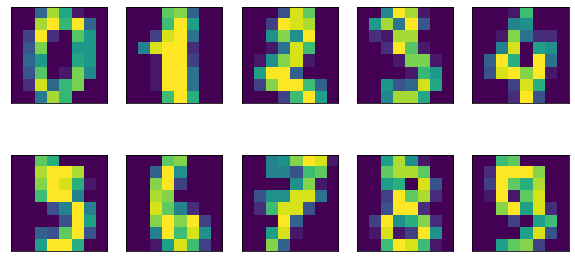

In [24]:
from sklearn.datasets import load_digits

digits = load_digits()
fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={"xticks": (), "yticks": ()})
for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img)

### PCA on digits  

- Let's try PCA and visualize digits in two dimensions. 

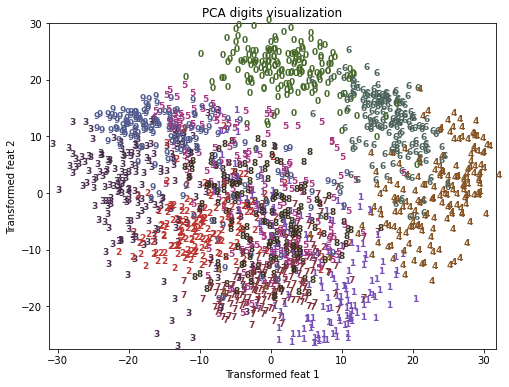

In [25]:
pca = PCA(n_components=2)
pca.fit(digits.data)
digits_pca = pca.transform(digits.data)
plot_digits(digits, digits_pca, title="PCA digits visualization")

### t-SNE on digits 

- Let's try t-SNE to visualize digits in two dimensions. 
- t-SNE cannot be used to transform new data. 
- So we use `fit_transform` instead of `fit`, as TSNE has no transform method. 

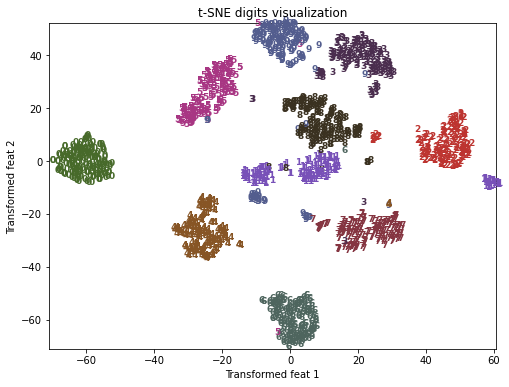

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)
digits_tsne = tsne.fit_transform(digits.data)
plot_digits(digits, digits_tsne, title="t-SNE digits visualization")

### Results of t-SNE 

- Almost all classes are clearly separated and form a single dense group. 
- Impressive given that it's a completely unsupervised method. 
- It's placing the points in two dimensions solely based on how close the points are in the original space. 
- Axes are not usually meaningful and do not correspond to anything in the input space.

![](img/t-sne-viz.gif)

[Source](https://github.com/oreillymedia/t-SNE-tutorial)

### Important hyperparameter: `perplexity`

- Intuitively it refers to the bandwidth of neighbours to consider
    - low perplexity: consider only close neighbours
    - smaller datasets try lower perplexity
    - authors say perplexity of 30 always works well! 🪄     

Let's examine different perplexity values on the digits dataset. 

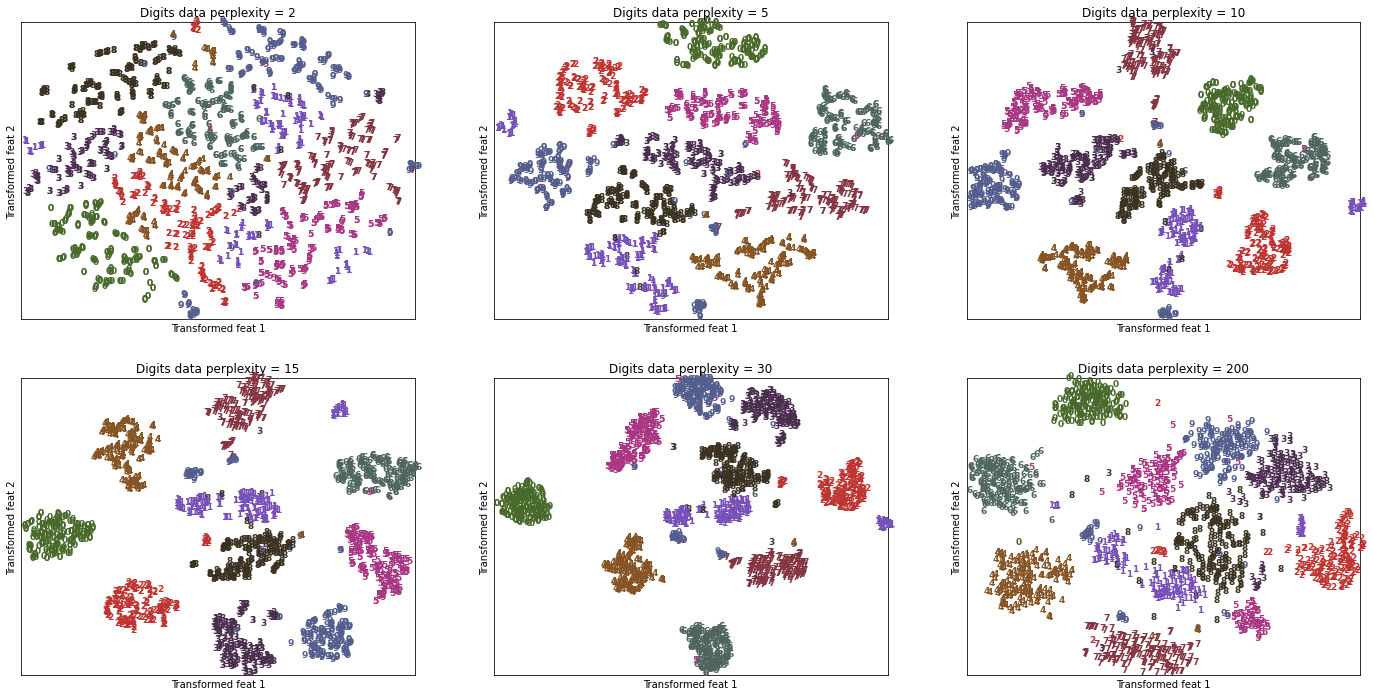

In [27]:
plot_perplexity_tsne(digits)

### Observations

- For `perplexity=2` we only consider close neighbourhoods so the clusters do not look compact. 
- Perplexity values of 10, 15, 30 seem to produce reasonable clusters. 
- Perplexity of 30 is actually producing most compact clusters!! 

### Important points about t-SNE

- Start with a random embedding
- Iteratively update points to make "close" points close.
- Local distances are more important and global distances are less important. 
- Good for getting coarse view of topology.
- Can be good for finding interesting data point
- t-distribution heavy-tailed so no overcrowding.
- low perplexity: only close neighbors 

<br><br><br><br>

## ❓❓ Questions for you
iClicker cloud join link: https://join.iclicker.com/MA16T

### Exercise 6.2 Select all of the following statements which are **True** (iClicker)

- (A) In product recommendation application of Word2Vec, we are not using item descriptions when training the model. 
- (B) Similar to PCA, t-SNE is a linear dimensionality reduction technique. 
- (C) If we carry our dimensionality reduction with t-SNE on the digits dataset, and pass the transformed data to a supervised machine learning algorithm it's likely to give us better results compared to training a supervised model with the raw pixel data of hand-written digits.

<br><br><br><br>

```{admonition} Exercise 6.2: V's Solutions!
:class: tip, dropdown

- (A) True. In our setup we are only using purchase histories of stock ids.
- (B) False. t-SNE is a non-linear dimensionality reduction technique.
- (C) True. t-SNE seems to be giving us nice well-separated clusters in this case. and it seems to solve the supervised problem for us here. It's true that you cannot apply t-SNE transformations on new data. But given new examples, you can always rerun your model.
```

Discuss the following questions. 

- Discuss how could you build a song recommendation system using Word2Vec. 
- Discuss the problems associated with Word2Vec recommendation systems. 

<br><br><br><br>

## Final comments, summary, reflection

### Summary: Using word embeddings 

- It's not that straightforward to effectively use word representations directly in text classification tasks but later when we learn about sequential models such as recurrent neural networks (RNNs) you'll appreciate word representations more.  
- Two simplistic ways to use word embeddings with traditional ML models. 
    - Averaging (noisy but works OK if your text is not too long)
    - Concatenating (we have to chop some text)
- We can use them more naturally with sequential models such as recurrent neural networks (DSCI 575).

### Summary: Word2Vec beyond words  

- Word2Vec is not limited to text and words. You can use it wherever distributional hypothesis makes sense. 
- We looked an application of Word2Vec for product recommendation. 

### Summary: Manifold learning with t-SNE

- Manifold learning algorithms apply complicated transformations on the data.  
    - Useful for pretty pictures and visualization. 
    - Usually we cannot use them to transform new data.     
- t-SNE focuses on neighbouring distances by allowing large variance in other distances. 
    - A popular technique used for visualizing high dimensional data
    - Usually produces well-separated and compact clusters compared to PCA
    - Axes do not correspond to anything meaningful in the input space    

### Reflection (~4 mins)

- Go to this [Google doc](https://docs.google.com/document/d/1RXXXn7WOdU2uxKJv5eDAyZJ9DB1WMzucnBSVX0XpYJE/edit#heading=h.jfxpzk866vxj) and answer the following questions. 
    - What is your takeaway from this lesson? 
    - What concepts from this lesson you are still struggling with? 

## Resources

- [t-SNE StatQuest](https://www.youtube.com/watch?v=NEaUSP4YerM)
- [t-SNE tutorial](https://github.com/oreillymedia/t-SNE-tutorial)
- [How to use t-SNE effectively](https://distill.pub/2016/misread-tsne/)
- [LargeVis](https://github.com/elbamos/largeVis)
- [UMAP](https://github.com/lmcinnes/umap)


<br><br><br><br>